In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole

from itertools import combinations

import IPython
from IPython.display import display, Image
from PIL import Image

import numpy as np
import pandas as pd

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("SMILES_Big_Data_Set.csv")
df.head(5)

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


In [4]:
import re
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train) 
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(2048, activation='sigmoid'))  # Output size 2048 for molecular fingerprint
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = np.zeros((batch_size, 2048))  # Adjust target shape to match model output
            if not done:
                target = (reward + self.gamma * np.argmax(self.target_model.predict(next_state.reshape(1, self.state_size))[0]))
            target_f = self.model.predict(state.reshape(1, self.state_size))
            target_f[0] = target
            self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    Drug Design Environment

    Args:
        num_features (int): Number of features for each molecule
        num_actions (int): Number of actions (molecules) to choose from
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        self.reward = 0
        self.target = np.ones((self.num_features,))  # Target vector (molecular fingerprint) is 2048-dimensional
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Compute the reward based on the similarity between the current state and the target"""
        similarity = np.dot(self.current_state, self.target)
        return similarity / self.num_actions

    def _is_done(self):
        """Check if the maximum number of steps has been reached"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Return the SMILES string representation of the current state."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string

    def step(self, action):
        """
        Execute a step in the environment
        Args:
            action (int): The action taken by the agent

        Returns:
            Tuple[np.ndarray, float, bool]: Tuple containing the next state, reward, and done flag
        """
        # Ensure the action is within the valid range
        action = max(0, min(action, self.num_actions - 1))
        next_state = np.zeros((self.num_features,))
        next_state[action] = 1.0
        self.current_state = next_state
        reward = self._get_reward()
        done = self._is_done()
        self.generated_smiles.append(action)
        return self.current_state, reward, done

    def reset(self):
        """Reset the environment"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state


def simulate(agent, env, batch_size, max_episodes, X_train, y_train):
    """
    Simulate the training process of the agent in the environment

    Args:
        agent (DRLAgent): The Deep Reinforcement Learning Agent
        env (DrugDesignEnv): The Drug Design Environment
        batch_size (int): Size of the minibatch for replay
        max_episodes (int): Maximum number of episodes to run
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    Returns:
        rewards (list): List of episode rewards.
        generated_smiles (list): List of generated SMILES strings
    """
    episode = 0
    rewards = []
    generated_smiles = []
    while episode < max_episodes:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Select a subset of training data for the current episode
        indices = np.random.choice(len(X_train), batch_size, replace=False)
        selected_X_train = [X_train[i] for i in indices]
        selected_y_train = y_train[indices]

        selected_X_train = np.array(selected_X_train)

        # Convert selected_y_train to a numpy array with correct shape
        selected_y_train = np.reshape(selected_y_train, (batch_size, 2048))  # Ensure shape matches model output

        agent.model.fit(selected_X_train, selected_y_train, epochs=1, verbose=0)

        episode += 1
        agent.update_target_model()
        rewards.append(episode_reward)
        generated_smiles.append(env.get_smiles())

    return rewards, generated_smiles


def smiles_to_fp_array(smiles):
    """
    Convert a SMILES string to a fingerprint array

    Args:
        smiles (str): SMILES string

    Returns:
        fp_array (ndarray): Fingerprint array
    """
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    return fp_array


def prepare_data():
    # Load and preprocess your data
    smiles = df['SMILES'].tolist()

    # Split the data into training and testing sets
    X_train, y_train = train_test_split(smiles, test_size=0.2, random_state=42)

    num_train_samples = min(len(X_train), len(y_train))
    selected_indices = random.sample(range(num_train_samples), num_train_samples)

    X_train = [X_train[i] for i in selected_indices]
    y_train = np.array([smiles_to_fp_array(smiles[i]) for i in selected_indices])

    return np.array(X_train), y_train


# Main function to simulate the agent's training and environment interaction
def main():
    # Prepare the data
    X_train, y_train = prepare_data()

    state_size = X_train.shape[1]
    action_size = 5  # Number of possible actions (molecular features)
    agent = DRLAgent(state_size, action_size, X_train)

    # Initialize the environment
    env = DrugDesignEnv(state_size, action_size, X_train, y_train)

    # Simulate agent's training in the environment
    rewards, generated_smiles = simulate(agent, env, batch_size=32, max_episodes=1000, X_train=X_train, y_train=y_train)

    # Plot the rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    # Save the trained model
    # agent.save('trained_model.h5')

if __name__ == "__main__":
    main()


[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerator
[14:17:18] DEPRECATION WARNING: please use MorganGenerat

IndexError: tuple index out of range

[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerator
[15:13:52] DEPRECATION WARNING: please use MorganGenerat

1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerator
[15:13:57] DEPRECATION WARNING: please use MorganGenerat

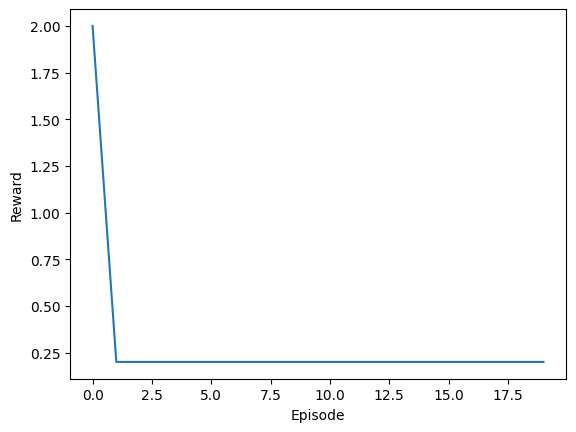

In [ ]:
import re
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
        selected_X_train (ndarray): The training features
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        self.target_model = self._build_model(selected_X_train)
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(2048,), activation='relu'))  # Expecting 2048 features as input
        model.add(Dense(16, activation='relu'))
        model.add(Dense(2048, activation='sigmoid'))  # Output size 2048 for molecular fingerprint
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store the experience in the replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose an action given the current state"""
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """Train the model by replaying experiences from the replay memory"""
        if len(self.memory) < batch_size:
            return  # Skip replay if there are not enough samples

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = np.zeros((1, 2048))  # Adjust target shape to match model output
            if not done:
                target[0] = reward + self.gamma * np.argmax(self.target_model.predict(next_state.reshape(1, self.state_size))[0])
            else:
                target[0] = reward
            target_f = self.model.predict(state.reshape(1, self.state_size))
            target_f[0] = target
            self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    Drug Design Environment

    Args:
        num_features (int): Number of features for each molecule
        num_actions (int): Number of actions (molecules) to choose from
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        self.reward = 0
        self.target = np.ones((self.num_features,))  # Target vector (molecular fingerprint) is 2048-dimensional
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Compute the reward based on the similarity between the current state and the target"""
        similarity = np.dot(self.current_state, self.target)
        return similarity / self.num_actions

    def _is_done(self):
        """Check if the maximum number of steps has been reached"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Return the SMILES string representation of the current state."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string

    def step(self, action):
        """
        Execute a step in the environment
        Args:
            action (int): The action taken by the agent

        Returns:
            Tuple[np.ndarray, float, bool]: Tuple containing the next state, reward, and done flag
        """
        # Ensure the action is within the valid range
        action = max(0, min(action, self.num_actions - 1))
        next_state = np.zeros((self.num_features,))
        next_state[action] = 1.0
        self.current_state = next_state
        reward = self._get_reward()
        done = self._is_done()
        self.generated_smiles.append(action)
        return self.current_state, reward, done

    def reset(self):
        """Reset the environment"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state


def simulate(agent, env, batch_size, max_episodes, X_train, y_train):
    """Simulate the training process of the agent in the environment"""
    episode = 0
    rewards = []
    generated_smiles = []
    while episode < max_episodes:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Select a subset of training data for the current episode
        indices = np.random.choice(len(X_train), batch_size, replace=False)

        # Convert SMILES to fingerprints and ensure the correct shape
        selected_X_train = [smiles_to_fp_array(X_train[i]) for i in indices]  # Convert SMILES to fingerprint arrays
        selected_X_train = np.array(selected_X_train)  # Convert to numpy array of shape (batch_size, 2048)
        selected_y_train = y_train[indices]

        # Ensure that y_train is also in the correct shape
        selected_y_train = np.array([y.reshape(-1) for y in selected_y_train])  # Each target should be 2048-dimensional

        # Fit the model on the selected data
        agent.model.fit(selected_X_train, selected_y_train, epochs=1, verbose=0)

        episode += 1
        agent.update_target_model()
        rewards.append(episode_reward)
        generated_smiles.append(env.get_smiles())

    return rewards, generated_smiles



def smiles_to_fp_array(smiles):
    """Convert a SMILES string to a fingerprint array"""
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    return fp_array


def prepare_data():
    """Prepare and preprocess the training data"""
    smiles = df['SMILES'].tolist()

    # Split the data into training and testing sets
    X_train, y_train = train_test_split(smiles, test_size=0.2, random_state=42)

    num_train_samples = min(len(X_train), len(y_train))
    selected_indices = random.sample(range(num_train_samples), num_train_samples)

    X_train = [X_train[i] for i in selected_indices]
    y_train = np.array([smiles_to_fp_array(smiles[i]) for i in selected_indices])

    return np.array(X_train), y_train


# Main function to simulate the agent's training and environment interaction
def main():
    # Prepare the data
    X_train, y_train = prepare_data()

    state_size = 2048
    action_size = 5  # Number of possible actions (molecular features)
    agent = DRLAgent(state_size, action_size, X_train)

    # Initialize the environment
    env = DrugDesignEnv(state_size, action_size, X_train, y_train)

    # Simulate agent's training in the environment
    rewards, generated_smiles = simulate(agent, env, batch_size=32, max_episodes=20, X_train=X_train, y_train=y_train)

    # Plot the rewards
    # print(generated_smiles[0])
    # fingerprint_str = ''.join(str(int(bit)) for bit in generated_smiles[0].split())
    # print(fingerprint_str)
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    # Save the trained model
    # agent.save('trained_model.h5')

if __name__ == "__main__":
    main()


[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerator
[15:27:54] DEPRECATION WARNING: please use MorganGenerat

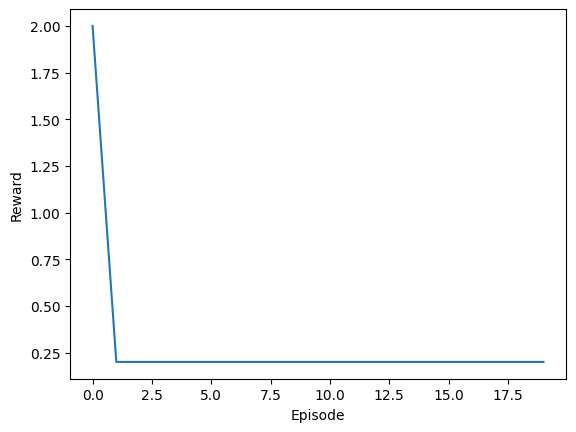

AttributeError: 'int' object has no attribute 'toList'

In [ ]:
import re
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
        selected_X_train (ndarray): The training features
    """
    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        self.target_model = self._build_model(selected_X_train)
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(2048,), activation='relu'))  # Expecting 2048 features as input
        model.add(Dense(16, activation='relu'))
        model.add(Dense(2048, activation='sigmoid'))  # Output size 2048 for molecular fingerprint
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store the experience in the replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose an action given the current state"""
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """Train the model by replaying experiences from the replay memory"""
        if len(self.memory) < batch_size:
            return  # Skip replay if there are not enough samples

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = np.zeros((1, 2048))  # Adjust target shape to match model output
            if not done:
                target[0] = reward + self.gamma * np.argmax(self.target_model.predict(next_state.reshape(1, self.state_size))[0])
            else:
                target[0] = reward
            target_f = self.model.predict(state.reshape(1, self.state_size))
            target_f[0] = target
            self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    Drug Design Environment

    Args:
        num_features (int): Number of features for each molecule
        num_actions (int): Number of actions (molecules) to choose from
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        self.reward = 0
        self.target = np.ones((self.num_features,))  # Target vector (molecular fingerprint) is 2048-dimensional
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Compute the reward based on the similarity between the current state and the target"""
        similarity = np.dot(self.current_state, self.target)
        return similarity / self.num_actions

    def _is_done(self):
        """Check if the maximum number of steps has been reached"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Return the SMILES string representation of the current state."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string

    def step(self, action):
        """
        Execute a step in the environment
        Args:
            action (int): The action taken by the agent

        Returns:
            Tuple[np.ndarray, float, bool]: Tuple containing the next state, reward, and done flag
        """
        # Ensure the action is within the valid range
        action = max(0, min(action, self.num_actions - 1))
        next_state = np.zeros((self.num_features,))
        next_state[action] = 1.0
        self.current_state = next_state
        reward = self._get_reward()
        done = self._is_done()
        self.generated_smiles.append(action)
        return self.current_state, reward, done

    def reset(self):
        """Reset the environment"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state


def simulate(agent, env, batch_size, max_episodes, X_train, y_train):
    """Simulate the training process of the agent in the environment"""
    episode = 0
    rewards = []
    generated_smiles = []
    while episode < max_episodes:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Select a subset of training data for the current episode
        indices = np.random.choice(len(X_train), batch_size, replace=False)

        # Convert SMILES to fingerprints and ensure the correct shape
        selected_X_train = [smiles_to_fp_array(X_train[i]) for i in indices]  # Convert SMILES to fingerprint arrays
        selected_X_train = np.array(selected_X_train)  # Convert to numpy array of shape (batch_size, 2048)
        selected_y_train = y_train[indices]

        # Ensure that y_train is also in the correct shape
        selected_y_train = np.array([y.reshape(-1) for y in selected_y_train])  # Each target should be 2048-dimensional

        # Fit the model on the selected data
        agent.model.fit(selected_X_train, selected_y_train, epochs=1, verbose=0)

        episode += 1
        agent.update_target_model()
        rewards.append(episode_reward)
        generated_smiles.append(env.get_smiles())

    return rewards, generated_smiles


def smiles_to_fp_array(smiles):
    """Convert a SMILES string to a fingerprint array"""
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    return fp_array


def fp_array_to_smiles(fp_array, X_train):
    """Convert a fingerprint array back to a SMILES string (simplified version)"""
    # Calculate the closest match in the training set based on fingerprint similarity
    best_match_idx = None
    max_similarity = -1

    for i, training_fp in enumerate(X_train):
        similarity = np.dot(fp_array, training_fp)
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_idx = i

    return X_train[best_match_idx]


def prepare_data():
    """Prepare and preprocess the training data"""
    smiles = df['SMILES'].tolist()

    # Split the data into training and testing sets
    X_train, y_train = train_test_split(smiles, test_size=0.2, random_state=42)

    num_train_samples = min(len(X_train), len(y_train))
    selected_indices = random.sample(range(num_train_samples), num_train_samples)

    X_train = [X_train[i] for i in selected_indices]
    y_train = np.array([smiles_to_fp_array(smiles[i]) for i in selected_indices])

    return np.array(X_train), y_train


# Main function to simulate the agent's training and environment interaction
def main():
    # Prepare the data
    X_train, y_train = prepare_data()

    state_size = 2048
    action_size = 5  # Number of possible actions (molecular features)
    agent = DRLAgent(state_size, action_size, X_train)

    # Initialize the environment
    env = DrugDesignEnv(state_size, action_size, X_train, y_train)

    # Simulate agent's training in the environment
    rewards, generated_smiles = simulate(agent, env, batch_size=32, max_episodes=20, X_train=X_train, y_train=y_train)

    # Plot the rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    # Print the SMILES generated from fingerprints
    for fingerprint in generated_smiles:
        fp_array = np.array([int(x) for x in fingerprint])
        smiles = fp_array_to_smiles(fp_array, X_train)
        print(smiles)

    # Save the trained model
    # agent.save('trained_model.h5')

if __name__ == "__main__":
    main()
